In [33]:
import tensorflow as tf
from os import listdir, path
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from pickle import dump, load
import numpy as np
import string
import re
import matplotlib.pyplot as plt

**Prepare Photo Data**

In [4]:
# extract features from each photo in the directory
def extract_features(directory):
    model = VGG16()
    # restructure the model
    # model.layers.pop()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    model.summary()

    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        filename = path.join(directory, name)
        image = load_img(filename, target_size = (224,224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image) # prepare img for VGG
        feature = model.predict(image, verbose = 0) # get features
        image_id = name.split('.')[0]
        features[image_id] = feature
        #print(name)
    return features

In [5]:
directory = 'Images'
features = extract_features(directory)
print(f"Extracted Features: {len(features)}")

# save the file
dump(features, open('features.pkl', 'wb'))

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 56, 56, 1

**Prepare Text Data**

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [4]:
def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile(f"[{re.escape(string.punctuation)}]")
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [re_punc.sub('', w) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

In [5]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [6]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [8]:
filename= '/kaggle/input/flickr8k/captions.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
clean_descriptions(descriptions)

vocabulary = to_vocabulary(descriptions)
print(f'Vocabulary Size: {len(vocabulary)}')

save_descriptions(descriptions, 'descriptions.txt')

Vocabulary Size: 8680


**Develope Deep learning Model**

In [7]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [8]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [9]:
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [10]:
# load training dataset
filename= '/kaggle/input/partitions/Flickr_8k.trainImages.txt'
train = load_set(filename)
print(f'Dataset: {len(train)}')

Dataset: 6000


In [11]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [12]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [13]:
def calculate_max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [14]:
# create sequences of images, input and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    x1, x2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple x, y pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequences
                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                # encode output sequences
                out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                x1.append(photos[key][0])
                x2.append(in_seq)
                y.append(out_seq)
    return np.array(x1), np.array(x2), np.array(y)

In [15]:
# create data generator to get data in batch (avoids session crash)
def data_generator(descriptions, tokenizer, max_length, batch_size):
    keys = list(descriptions.keys())
    while True:
        #np.random.shuffle(keys)
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i + batch_size]
            batch_descriptions = {k: descriptions[k] for k in batch_keys}
            x1, x2, y = create_sequences(tokenizer, max_length, batch_descriptions)
            yield [x1, x2], y

In [31]:
def batch_data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in descriptions.items():
            n += 1
            photo = features[key][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                    if n == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [23]:
# The captioning Model
def define_model(vocab_size, max_length):

    # feature extractor model
    inputs1 = Input(shape = (4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation = 'relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

    model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    model.summary()

    plot_model(model, to_file = 'model.png', show_shapes = True)
    return model

In [19]:
train_descriptions = load_clean_descriptions('/kaggle/input/uploads/descriptions.txt', train)
train_features = load_photo_features('/kaggle/input/uploads/features.pkl', train)

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab_size: {vocab_size}')

max_length = calculate_max_length(train_descriptions)
print(f'Max Sequence length: {max_length}')

# # prepare sequences
# x1_train, x2_train, y_train = create_sequences(tokenizer, max_length, train_descriptions, train_features)
# print('prepared train sequences')

# load test set
filename = '/kaggle/input/partitions/Flickr_8k.devImages.txt'
test = load_set(filename)
test_descriptions = load_clean_descriptions('/kaggle/input/uploads/descriptions.txt', test)
test_features = load_photo_features('/kaggle/input/uploads/features.pkl', test)
print('loaded test set')

# x1_test, x2_test, y_test = create_sequences(tokenizer, max_length, test_descriptions, test_features)
# print('prepared test sequences')

Vocab_size: 7507
Max Sequence length: 33
loaded test set


In [32]:
# Calculate steps per epoch
epochs = 20
batch_size = 32
steps_per_epoch = len(train_descriptions) // batch_size
validation_steps = len(test_descriptions) // batch_size

train_generator = batch_data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
val_generator = batch_data_generator(test_descriptions, test_features, tokenizer, max_length, vocab_size, batch_size)

# Define and compile your model
model = define_model(vocab_size, max_length)

# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks = [checkpoint]

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 33, 256)   │  1,921,792 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 4096)      │          0 │ input_layer_12[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 33, 256)   │          0 │ embedding_6[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 33)        │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │  1,048,832 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 256)       │    525,312 │ dropout_13[0][0], │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 256)       │          0 │ dense_18[0][0],   │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 7507)      │  1,929,299 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,491,027 (20.95 MB)

 Trainable params: 5,491,027 (20.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 5.8712
Epoch 1: val_loss improved from inf to 4.45631, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 261ms/step - loss: 5.8682 - val_loss: 4.4563
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 4.2622
Epoch 2: val_loss improved from 4.45631 to 4.02766, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - loss: 4.2615 - val_loss: 4.0277
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 3.7578
Epoch 3: val_loss improved from 4.02766 to 3.91264, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 263ms/step - loss: 3.7574 - val_loss: 3.9126
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 3.4595
Epoch 4: val_loss improved from 3.91264 to 3.87082, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - loss: 3.4593 - val_loss: 3.8708
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 3.2348
Epoch 5

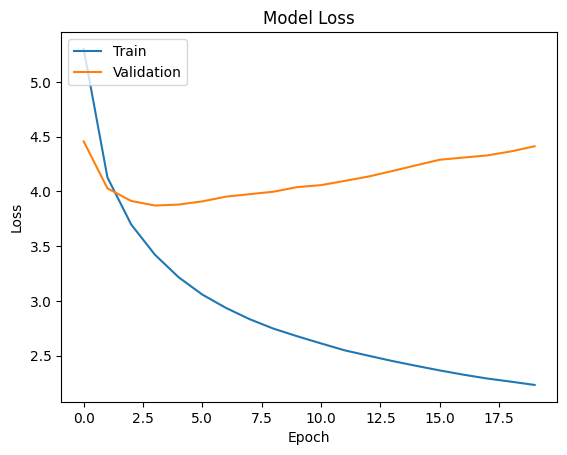

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()